In [1]:
using NBInclude
@nbinclude("functions.ipynb")
function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

function load_model_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

#using MosaicViews
#using ImageShow


All function imported


get_test_loader (generic function with 1 method)

In [2]:
z_inco_list = load("saved_data/MNIST_image_recovery_25.jld", "z_inco_list")
z_co_list = load("saved_data/MNIST_image_recovery_25.jld", "z_co_list")
x_true_list = load("saved_data/MNIST_image_recovery_25.jld", "x_true_list")
z_est_inco_matrix = load("saved_data/MNIST_image_recovery_25.jld", "z_est_inco_matrix")
z_est_co_matrix = load("saved_data/MNIST_image_recovery_25.jld", "z_est_co_matrix")
epoch = load("saved_data/MNIST_image_recovery_25.jld", "epoch")
m_list = load("saved_data/MNIST_image_recovery_25.jld", "m_list")


epoch_to_load_inco = epoch
dir_inco = "trained_GNN/MNIST_identity_v4"
encoder_μ_inco, encoder_logvar_inco, W1_inco, W2_inco, W3_inco, Q_inco = load_model_sep(dir_inco, epoch_to_load_inco);

# Load the model and test set loader unenforced
epoch_to_load_co = epoch
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, W1_co, W2_co, W3_co, Q_co = load_model_sep(dir_co, epoch_to_load_co);

#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 5000; out_toggle = 0


# G_inco(z) = decoder_last * decoder(z)
G_inco(z) =Q_inco *W3_inco*relu(W2_inco*relu(W1_inco*z))
G_co(z) = Q_co*relu(W2_co*relu(W1_co*z));


Loading model...Done
Loading model...Done


┌ Info: Saved animation to 
│   fn = /var/folders/p2/smmnhqzd3blf_bqyb4fp8b5h0000gn/T/jl_7PwVrQ.gif
└ @ Plots /Users/babhru/.julia/packages/Plots/E2187/src/animation.jl:126


Plots.AnimatedGif("/var/folders/p2/smmnhqzd3blf_bqyb4fp8b5h0000gn/T/jl_7PwVrQ.gif")
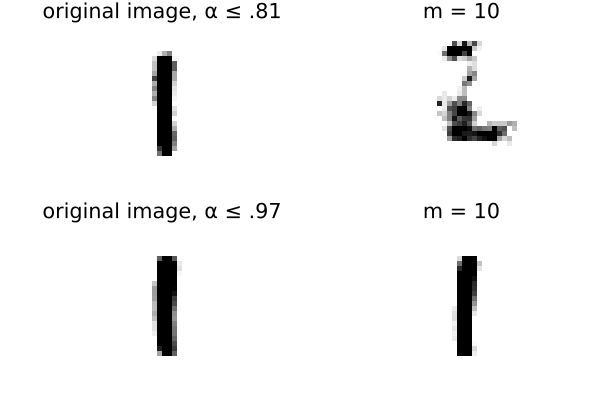

In [10]:
num = 1
z_inco = z_inco_list[num, :]
z_co = z_co_list[num, :]
x_true = x_true_list[num, :]
z_est_inco_list = z_est_inco_matrix[num,:,:]
z_est_co_list = z_est_co_matrix[num,:,:]

anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end
gif(anim, fps = 1)


In [38]:
using Plots.PlotMeasures
using Plots
using LaTeXStrings
z_inco = z_inco_list[num, :]
z_co = z_co_list[num, :]
x_true = x_true_list[num, :]
z_est_inco_list = z_est_inco_matrix[num,:,:]
z_est_co_list = z_est_co_matrix[num,:,:]
k = 10
nums = [1,4,5]
meas = [ 1, 2, 3, 4, 9, 10, 12 ,13]
num = 1
p = [plot(colorview(Gray, reshape(G_inco(z_inco_list[num,:]), 28,28)' ),framestyle = :box,ylabelfontsize =16, axis=([], false), ylabel = L"\alpha = 0.81", leftmargin=10mm ) ]
q = [plot(colorview(Gray, reshape(G_co(z_co_list[num,:]), 28,28)' ),framestyle = :box, ylabelfontsize =16, axis=([], false), ylabel = L"\alpha = 0.96")]
nums = [1,4,5]
meas = [ 1, 2, 3, 4, 9, 10, 12 ,13]
for index in 1:length(meas)
    m = meas[index]
    push!(p, plot(colorview(Gray, reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)' ),framestyle = :none, titlefontsize	= 20, topmargin=10mm,title = L"m = %$(m_list[m])" )) #
    push!(q, plot(colorview(Gray, reshape(G_co(z_est_co_matrix[num,:, m]), 28,28)' ),framestyle = :none))

end
plot1 = plot(p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8], p[9],
    q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8], q[9],
       layout = (2,9), size = (1200,250), rightmargin = 10mm)

savefig(plot1, "figures/Image_recov_1.pdf")

recon_error = []
for i in 1:length(m_list)
    recon_error = relative_error(G_inco(z_inco), G_inco(z_est_inco_list[:, i]))
end

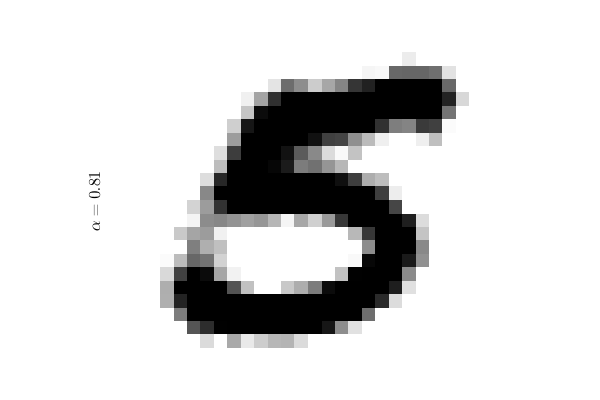

In [31]:
plot(colorview(Gray, reshape(G_inco(z_inco_list[num,:]), 28,28)' ),framestyle = :box,titlefontsiz =8, axis=([], false), ylabel = L"\alpha = 0.81" )

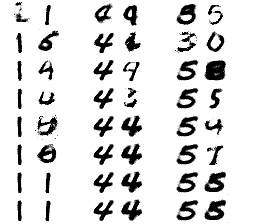

In [3]:
nums = [1,4,5]
meas = [ 1, 2, 3, 4, 9, 10, 12 ,13]
image = ones(28*length(meas),5)

for num in nums
    rec_inco_tensor = zeros(28,28,length(meas))
    rec_co_tensor = zeros(28,28,length(meas))
    for index in 1:length(meas)
        m = meas[index]
        rec_inco_tensor[:,:,index] = reshape(G_inco(z_est_inco_matrix[num,:, m]), 28,28)
        rec_co_tensor[:,:,index] = reshape(G_inco(z_est_co_matrix[num,:, m]), 28,28)
    end
    # print(size(rec_co_tensor))
    image = hcat(image, reshape(rec_inco_tensor, 28,28*length(meas) )', reshape(rec_co_tensor, 28,28*length(meas) )', ones(28*length(meas),28) )
end


colorview(Gray, image)